## 기본 설정(라이브러리, 한글 폰트, 데이터 불러오기)

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 한글 폰트 설정하기
!apt-get -qq install fonts-nanum*

import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/KUBIG/25-1/Basic Study_ML/train.csv')
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


## EDA

### 데이터셋 Brief View

**[ 변수 설명 ]**
- ID: 차량별 고유 ID
- 제조사: 차량 제조사(H사, B사, K사, A사, T사, P사, V사 총 7개의 제조사 중 하나)
- 모델: 차량 모델명(총 21개의 모델 중 하나)
- 차량상태: Brand New(신차), Nearly New(준신차), Pre-Owned(중고차)
- 배터리용량: 잔존 배터리용량(kWh 단위)
- 구동방식: AWD(사륜구동), FWD(전륜구동), RWD(후륜구동)
- 주행거리(km): 누적 주행거리
- 보증기간(년): 무상 수리 및 서비스 기간
- 사고이력: No, Yes
- 연식(년): 0, 1, 2로 이루어짐(ex. 연식이 1: 출시된 지 1년 된 차량)
- 가격(백만원)

In [ ]:
for col in train:
  if (train[col].dtype == 'object') & (col != 'ID'):
    print(train[col].value_counts())

제조사
H사    1237
B사    1169
K사    1164
A사    1142
T사    1109
P사    1071
V사     605
Name: count, dtype: int64
모델
ID4       605
i5        414
Niro      398
Soul      397
i3        388
RSeTGT    385
eT        379
ION6      379
Q4eT      378
TayGTS    375
EV6       369
iX        367
KNE       365
Tay       361
ION5      353
TayCT     335
MY        289
M3        279
MS        277
MX        264
IONIQ     140
Name: count, dtype: int64
차량상태
Brand New     3380
Nearly New    2059
Pre-Owned     2058
Name: count, dtype: int64
구동방식
AWD    5167
FWD    1267
RWD    1063
Name: count, dtype: int64
사고이력
No     7154
Yes     343
Name: count, dtype: int64


- 총 7497개의 행, 11개의 열로 이루어진 데이터</br>
- 배터리용량에만 2711개(36.16%)의 결측값 존재

In [ ]:
train.shape

(7497, 11)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [ ]:
print("[ 변수별 결측치 개수 및 비율 ]")
print(train.isna().sum())
print('--------------------')
for i in train.columns:
  missingValueRate = train[i].isna().sum() / len(train) * 100
  if missingValueRate > 0:
    print('{} null rate: {}%'.format(i, round(missingValueRate, 2)))

[ 변수별 결측치 개수 및 비율 ]
ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64
--------------------
배터리용량 null rate: 36.16%


### 범주형 변수 레이블 인코딩

- 범주형 변수의 범주 개수가 많아서 원핫 인코딩을 사용하면 차원이 너무 많아질 수 있으므로 LabelEncoder() 사용
- LabelEncoder()는 변수에 잘못된 순서를 부여할 수 있다는 단점이 있는데, 트리 모델은 숫자의 순서를 직접적으로 활용하지 않으며 다음 과정들에서 트리 모델을 주로 활용하였기 때문에 괜찮다고 판단

In [ ]:
# LabelEncoder 적용
label_mappings = {}
for col in train:
    if (train[col].dtype == 'object') & (col != 'ID'):
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        label_mappings[col] = dict(enumerate(le.classes_))

# 매핑 정보 확인
for col, mapping in label_mappings.items():
    print(f"{col} 매핑: {mapping}")

제조사 매핑: {0: 'A사', 1: 'B사', 2: 'H사', 3: 'K사', 4: 'P사', 5: 'T사', 6: 'V사'}
모델 매핑: {0: 'EV6', 1: 'ID4', 2: 'ION5', 3: 'ION6', 4: 'IONIQ', 5: 'KNE', 6: 'M3', 7: 'MS', 8: 'MX', 9: 'MY', 10: 'Niro', 11: 'Q4eT', 12: 'RSeTGT', 13: 'Soul', 14: 'Tay', 15: 'TayCT', 16: 'TayGTS', 17: 'eT', 18: 'i3', 19: 'i5', 20: 'iX'}
차량상태 매핑: {0: 'Brand New', 1: 'Nearly New', 2: 'Pre-Owned'}
구동방식 매핑: {0: 'AWD', 1: 'FWD', 2: 'RWD'}
사고이력 매핑: {0: 'No', 1: 'Yes'}


In [ ]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,4,16,1,86.077,0,13642,0,0,2,159.66
1,TRAIN_0001,3,10,1,56.000,1,10199,6,0,0,28.01
2,TRAIN_0002,0,17,0,91.200,0,2361,7,0,0,66.27
3,TRAIN_0003,0,12,1,NaN,0,21683,3,0,0,99.16
4,TRAIN_0004,1,19,2,61.018,0,178205,1,0,0,62.02


### 배터리용량 결측치 처리

#### 배터리용량과 다른 변수들 간 관계 확인

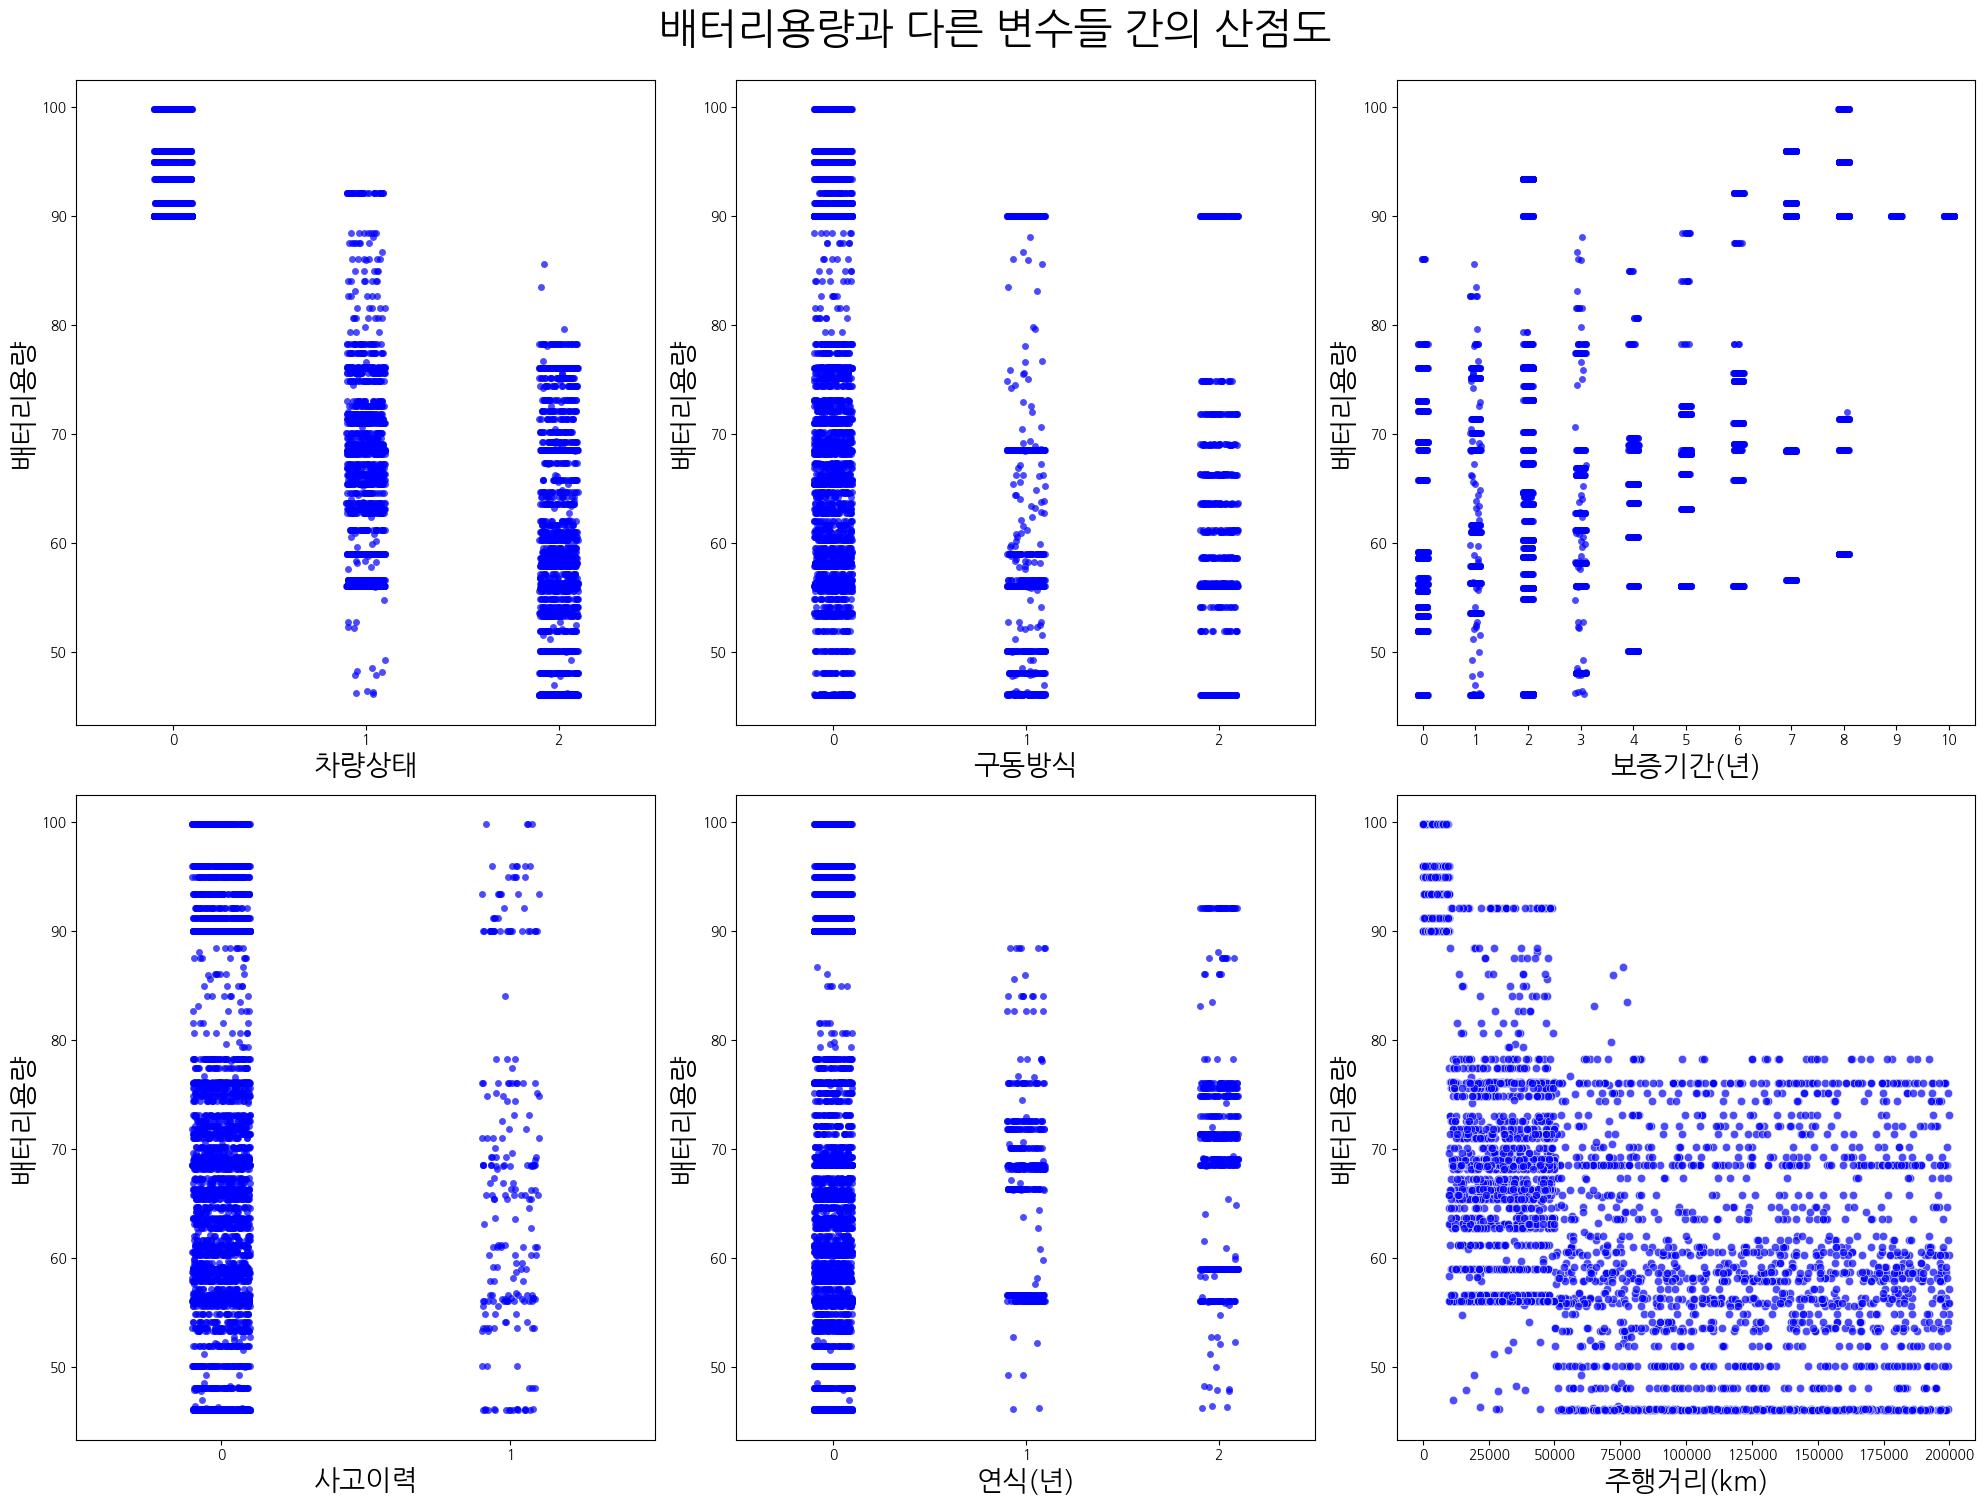

배터리용량과 차량상태 간의 상관계수: -0.7949794823254366
배터리용량과 주행거리(km) 간의 상관계수: -0.5765384147171888


In [ ]:
plt.figure(figsize = (20, 15))
plotnumber = 1

# 범주형 변수 - stripplot() 이용
for col in ['차량상태', '구동방식', '보증기간(년)', '사고이력', '연식(년)']:
  if plotnumber <= 5:
      ax = plt.subplot(2, 3, plotnumber)
      sns.stripplot(x = col, y = '배터리용량', data = train, alpha = 0.7, color = 'blue')
      plt.xlabel(col, fontsize = 20)
      plt.ylabel('배터리용량', fontsize = 20)
  plotnumber += 1

# 연속형 변수 - scatterplot() 이용
plt.subplot(2, 3, 6)
sns.scatterplot(x = '주행거리(km)', y = '배터리용량', data = train, alpha = 0.7, color = 'blue')
plt.xlabel('주행거리(km)', fontsize = 20)
plt.ylabel('배터리용량', fontsize = 20)

plt.suptitle("배터리용량과 다른 변수들 간의 산점도", y = 1, size = 30, fontweight = 'bold')
plt.tight_layout()
plt.show()

# 산점도에서 차량상태, 주행거리는 배터리용량과의 유의미한 관계가 있어보임 -> 상관계수 계산
print("배터리용량과 차량상태 간의 상관계수:", train["배터리용량"].corr(train["차량상태"]))
print("배터리용량과 주행거리(km) 간의 상관계수:", train["배터리용량"].corr(train["주행거리(km)"]))

- 차량상태와 주행거리(km)는 배터리용량과 유의미한 관계가 있다고 판단됨.
- 차량이 제조될 때부터 모델별 배터리용량에 차이가 존재하기 때문에 모델 변수도 배터리용량과 당연히 관계가 있을 것이라고 판단 -> 모델별 배터리용량의 평균값 활용

#### 결측치 대체값 생성

In [ ]:
# (1) 모델별 배터리용량의 평균 구하기(mean_battery_per_model) - map을 이용해서 각 행에 각 모델에 해당하는 평균 배터리용량 열(mean_battery) 추가
mean_battery_per_model = train.groupby('모델')['배터리용량'].mean()
train['mean_battery'] = train['모델'].map(mean_battery_per_model)

# (2) '배터리용량'이 결측값인 행은 제거하여 train 데이터셋 생성 - 독립변수(X)는 '차량상태', '주행거리', 'mean_battery', 타겟(y)는 '배터리용량'으로 설정
train_no_na = train.dropna(subset = ['배터리용량'])
X = train_no_na[['차량상태', '주행거리(km)', 'mean_battery']]
y = train_no_na['배터리용량']

# (3) Ridge 모델 학습 - RandomizedSearchCV를 이용하여 하이퍼파라미터 탐색
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

scaler1 = StandardScaler()
X = scaler1.fit_transform(X)

ridge = Ridge()

# 하이퍼파라미터 그리드
param_grid = {
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept' : [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}
# scoring 방식은 RMSE
ridge_cv_model = RandomizedSearchCV(ridge, param_grid, n_iter = 100,
                                    scoring = 'neg_root_mean_squared_error', cv = 5)
ridge_cv_model.fit(X, y)

print(f"Best Hyperparametes: {ridge_cv_model.best_params_}")

ridge_model = Ridge(alpha = ridge_cv_model.best_params_['alpha'],
                    fit_intercept = ridge_cv_model.best_params_['fit_intercept'],
                    solver = ridge_cv_model.best_params_['solver'])
ridge_model.fit(X, y)

# (4) '배터리용량'이 결측값인 행을 찾아서 예측값 생성 후 결측값 채우기
train_na = train[train['배터리용량'].isna()]
X_na = train_na[['차량상태', '주행거리(km)', 'mean_battery']]
X_na = scaler1.transform(X_na)
y_na_pred = ridge_model.predict(X_na)
train.loc[train['배터리용량'].isna(), '배터리용량'] = y_na_pred

Best Hyperparametes: {'solver': 'saga', 'fit_intercept': True, 'alpha': 0.0001}


In [ ]:
train.isna().sum().sum()
# 배터리용량 열의 결측값이 모두 사라진 것을 확인할 수 있음

0

RandomForestRegressor와 Ridge 회귀 두 가지 선택지 존재 <br>
- 두 변수 간의 선형 관계를 측정하는 상관계수가 배터리용량과 차량상태 간에는 -0.7949794823254366, 배터리용량과 주행거리(km) 간에는 -0.5765384147171888, 배터리용량과 mean_battery 간에는 0.7395676213138405로 매우 높은 값을 보이므로 선형 관계가 존재한다고 판단. <br>
- 따라서 Ridge 회귀를 이용하였고, 실제로 RandomForestRegressor도 이용해서 이후 모델을 적합해 본 결과, Ridge를 사용해서 결측치를 채웠을 때 모델 성능이 더 뛰어났음.
- 단, Ridge가 이상치에 민감하다는 점을 고려해서 StandardScaler를 이용한 표준화 진행


In [ ]:
correlation = train['mean_battery'].corr(train['배터리용량'])
print(f"상관계수: {correlation}")

상관계수: 0.7395477969908847


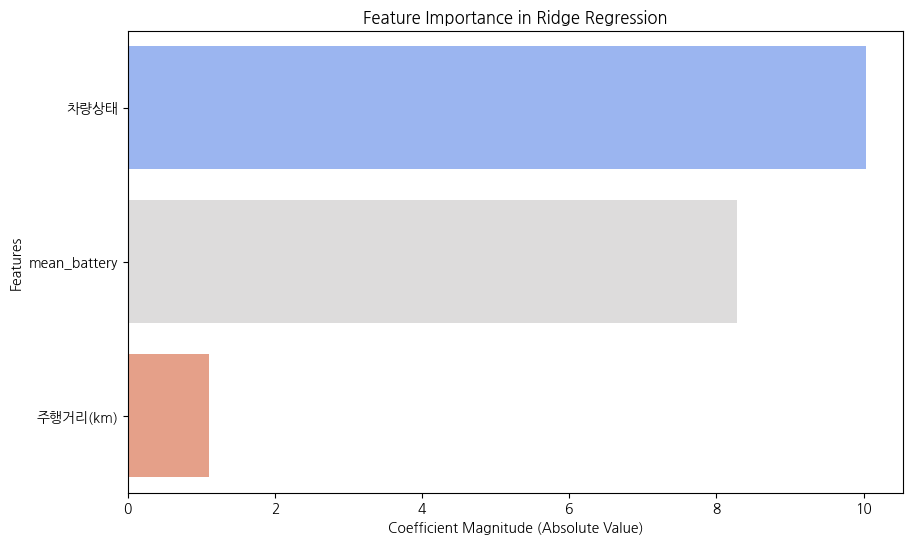

In [ ]:
# 배터리용량 예측 릿지 모델의 feature importance 시각화 (계수의 절댓값을 사용해 변수 중요도 해석)
# 변수 중요도(계수) 추출
feature_importance = np.abs(ridge_model.coef_)  # 계수의 절댓값을 중요도로 사용
feature_importance_df = pd.DataFrame({'Feature': ['차량상태', '주행거리(km)', 'mean_battery'], 'Importance': feature_importance})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='coolwarm')
plt.xlabel('Coefficient Magnitude (Absolute Value)')
plt.ylabel('Features')
plt.title('Feature Importance in Ridge Regression')
plt.show()

### 파생변수

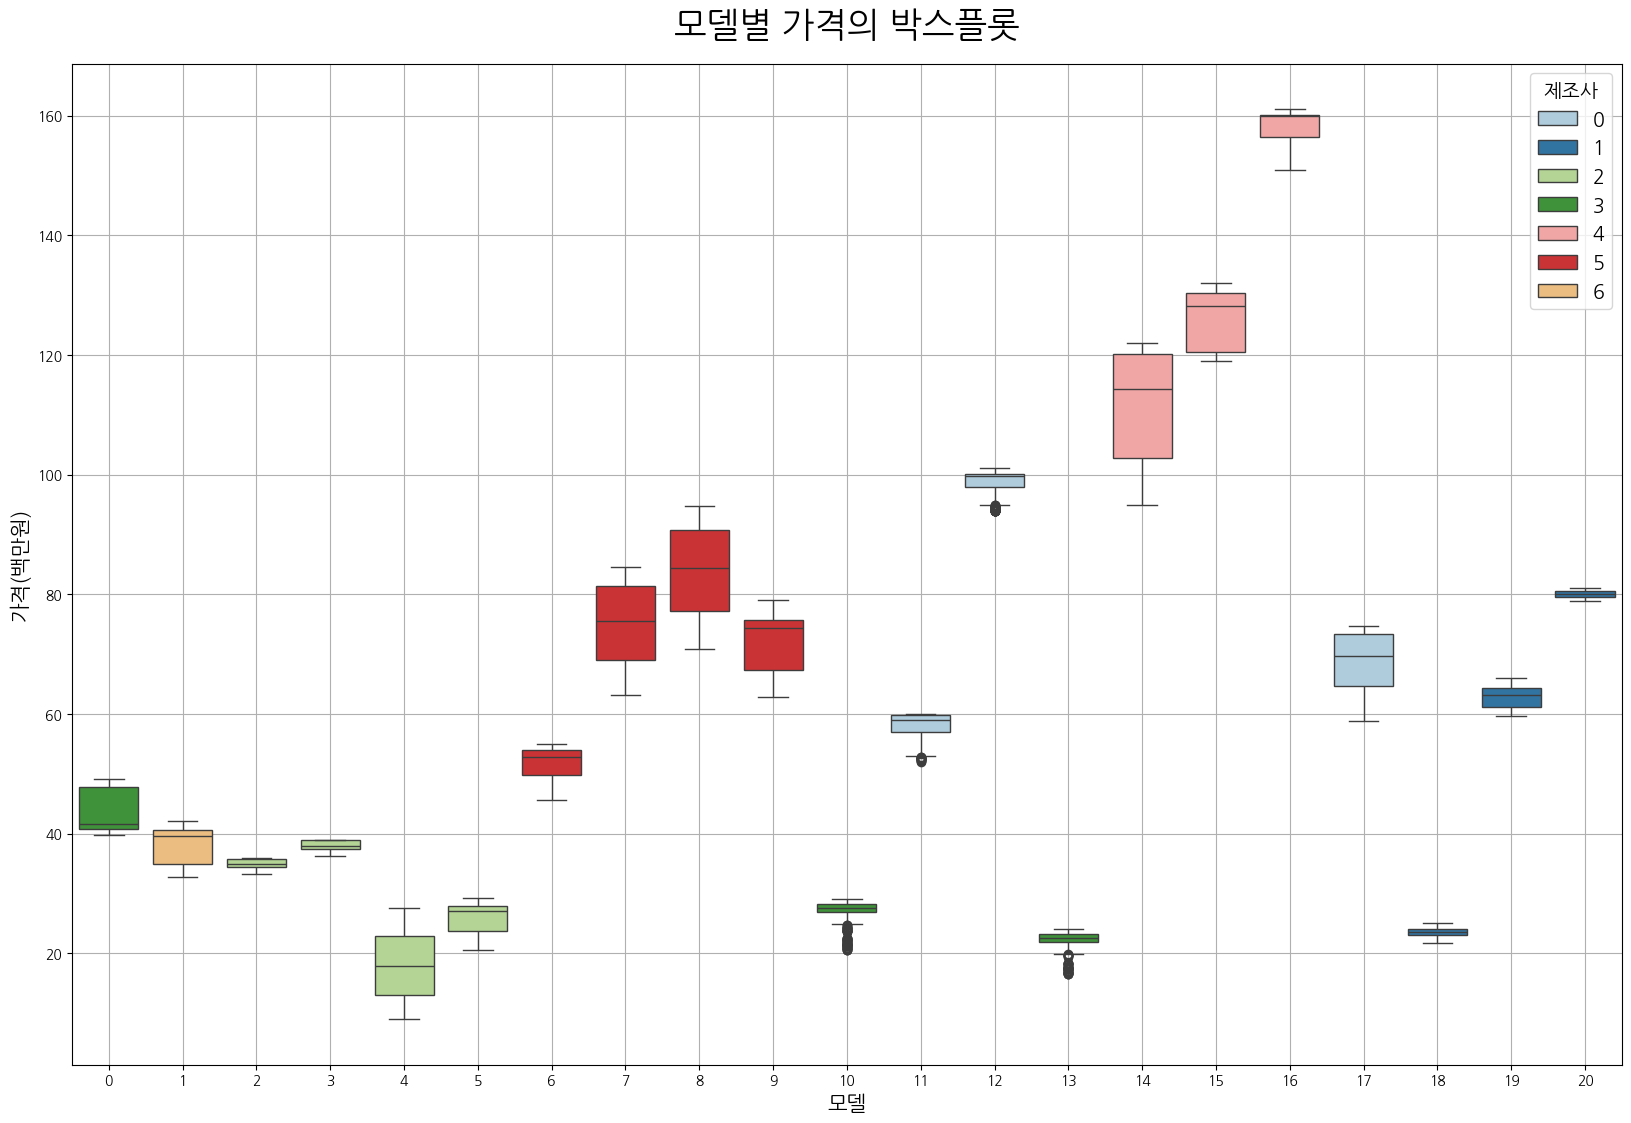

In [ ]:
plt.figure(figsize = (20, 13))
sns.boxplot(x = '모델', y = '가격(백만원)', hue = '제조사', data = train, palette = 'Paired')
plt.title('모델별 가격의 박스플롯', size = 25, fontweight = 'bold', y = 1.02)
plt.legend(title = '제조사', title_fontsize = 14, fontsize = 14)
plt.xlabel('모델', fontsize = 15)
plt.ylabel('가격(백만원)', fontsize = 15)
plt.grid(True)
plt.show()
# 같은 제조사의 차량이더라도 가격의 범위가 크게 차이가 나며, 같은 모델 안에서는 가격의 분산이 비교적 작아져 비슷한 값에 분포한다.
# 따라서 가격을 예측하려는 모델의 평균 가격을 알고 있다면, 가격 예측에 큰 도움이 될 것이다.

In [ ]:
mean_price = train.groupby(['모델'])['가격(백만원)'].mean()
train['모델평균가격'] = train['모델'].map(mean_price)
train = train.drop('mean_battery', axis = 1)

In [ ]:
# 연식 대비 주행거리 = 주행거리 / 연식

# 연식 = 0이면 그냥 주행거리(km) 값 그대로 사용
train['mileage_per_year'] = train.apply(
    lambda row: row['주행거리(km)'] / row['연식(년)'] if row['연식(년)'] != 0 else row['주행거리(km)'],
    axis=1)

train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),모델평균가격,mileage_per_year
0,TRAIN_0000,4,16,1,86.077000,0,13642,0,0,2,159.66,158.298747,6821.0
1,TRAIN_0001,3,10,1,56.000000,1,10199,6,0,0,28.01,26.970779,10199.0
2,TRAIN_0002,0,17,0,91.200000,0,2361,7,0,0,66.27,68.095251,2361.0
3,TRAIN_0003,0,12,1,81.584705,0,21683,3,0,0,99.16,98.801195,21683.0
4,TRAIN_0004,1,19,2,61.018000,0,178205,1,0,0,62.02,62.873382,178205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,2,2,0,81.553992,0,3773,10,0,0,35.95,35.070142,3773.0
7493,TRAIN_7493,1,18,2,46.000000,2,135411,2,0,0,23.40,23.561108,135411.0
7494,TRAIN_7494,4,15,0,89.369808,0,1363,2,0,0,120.00,126.312657,1363.0
7495,TRAIN_7495,1,18,1,56.000000,2,39445,6,0,2,24.00,23.561108,19722.5


### 시각화

#### 변수별 히스토그램

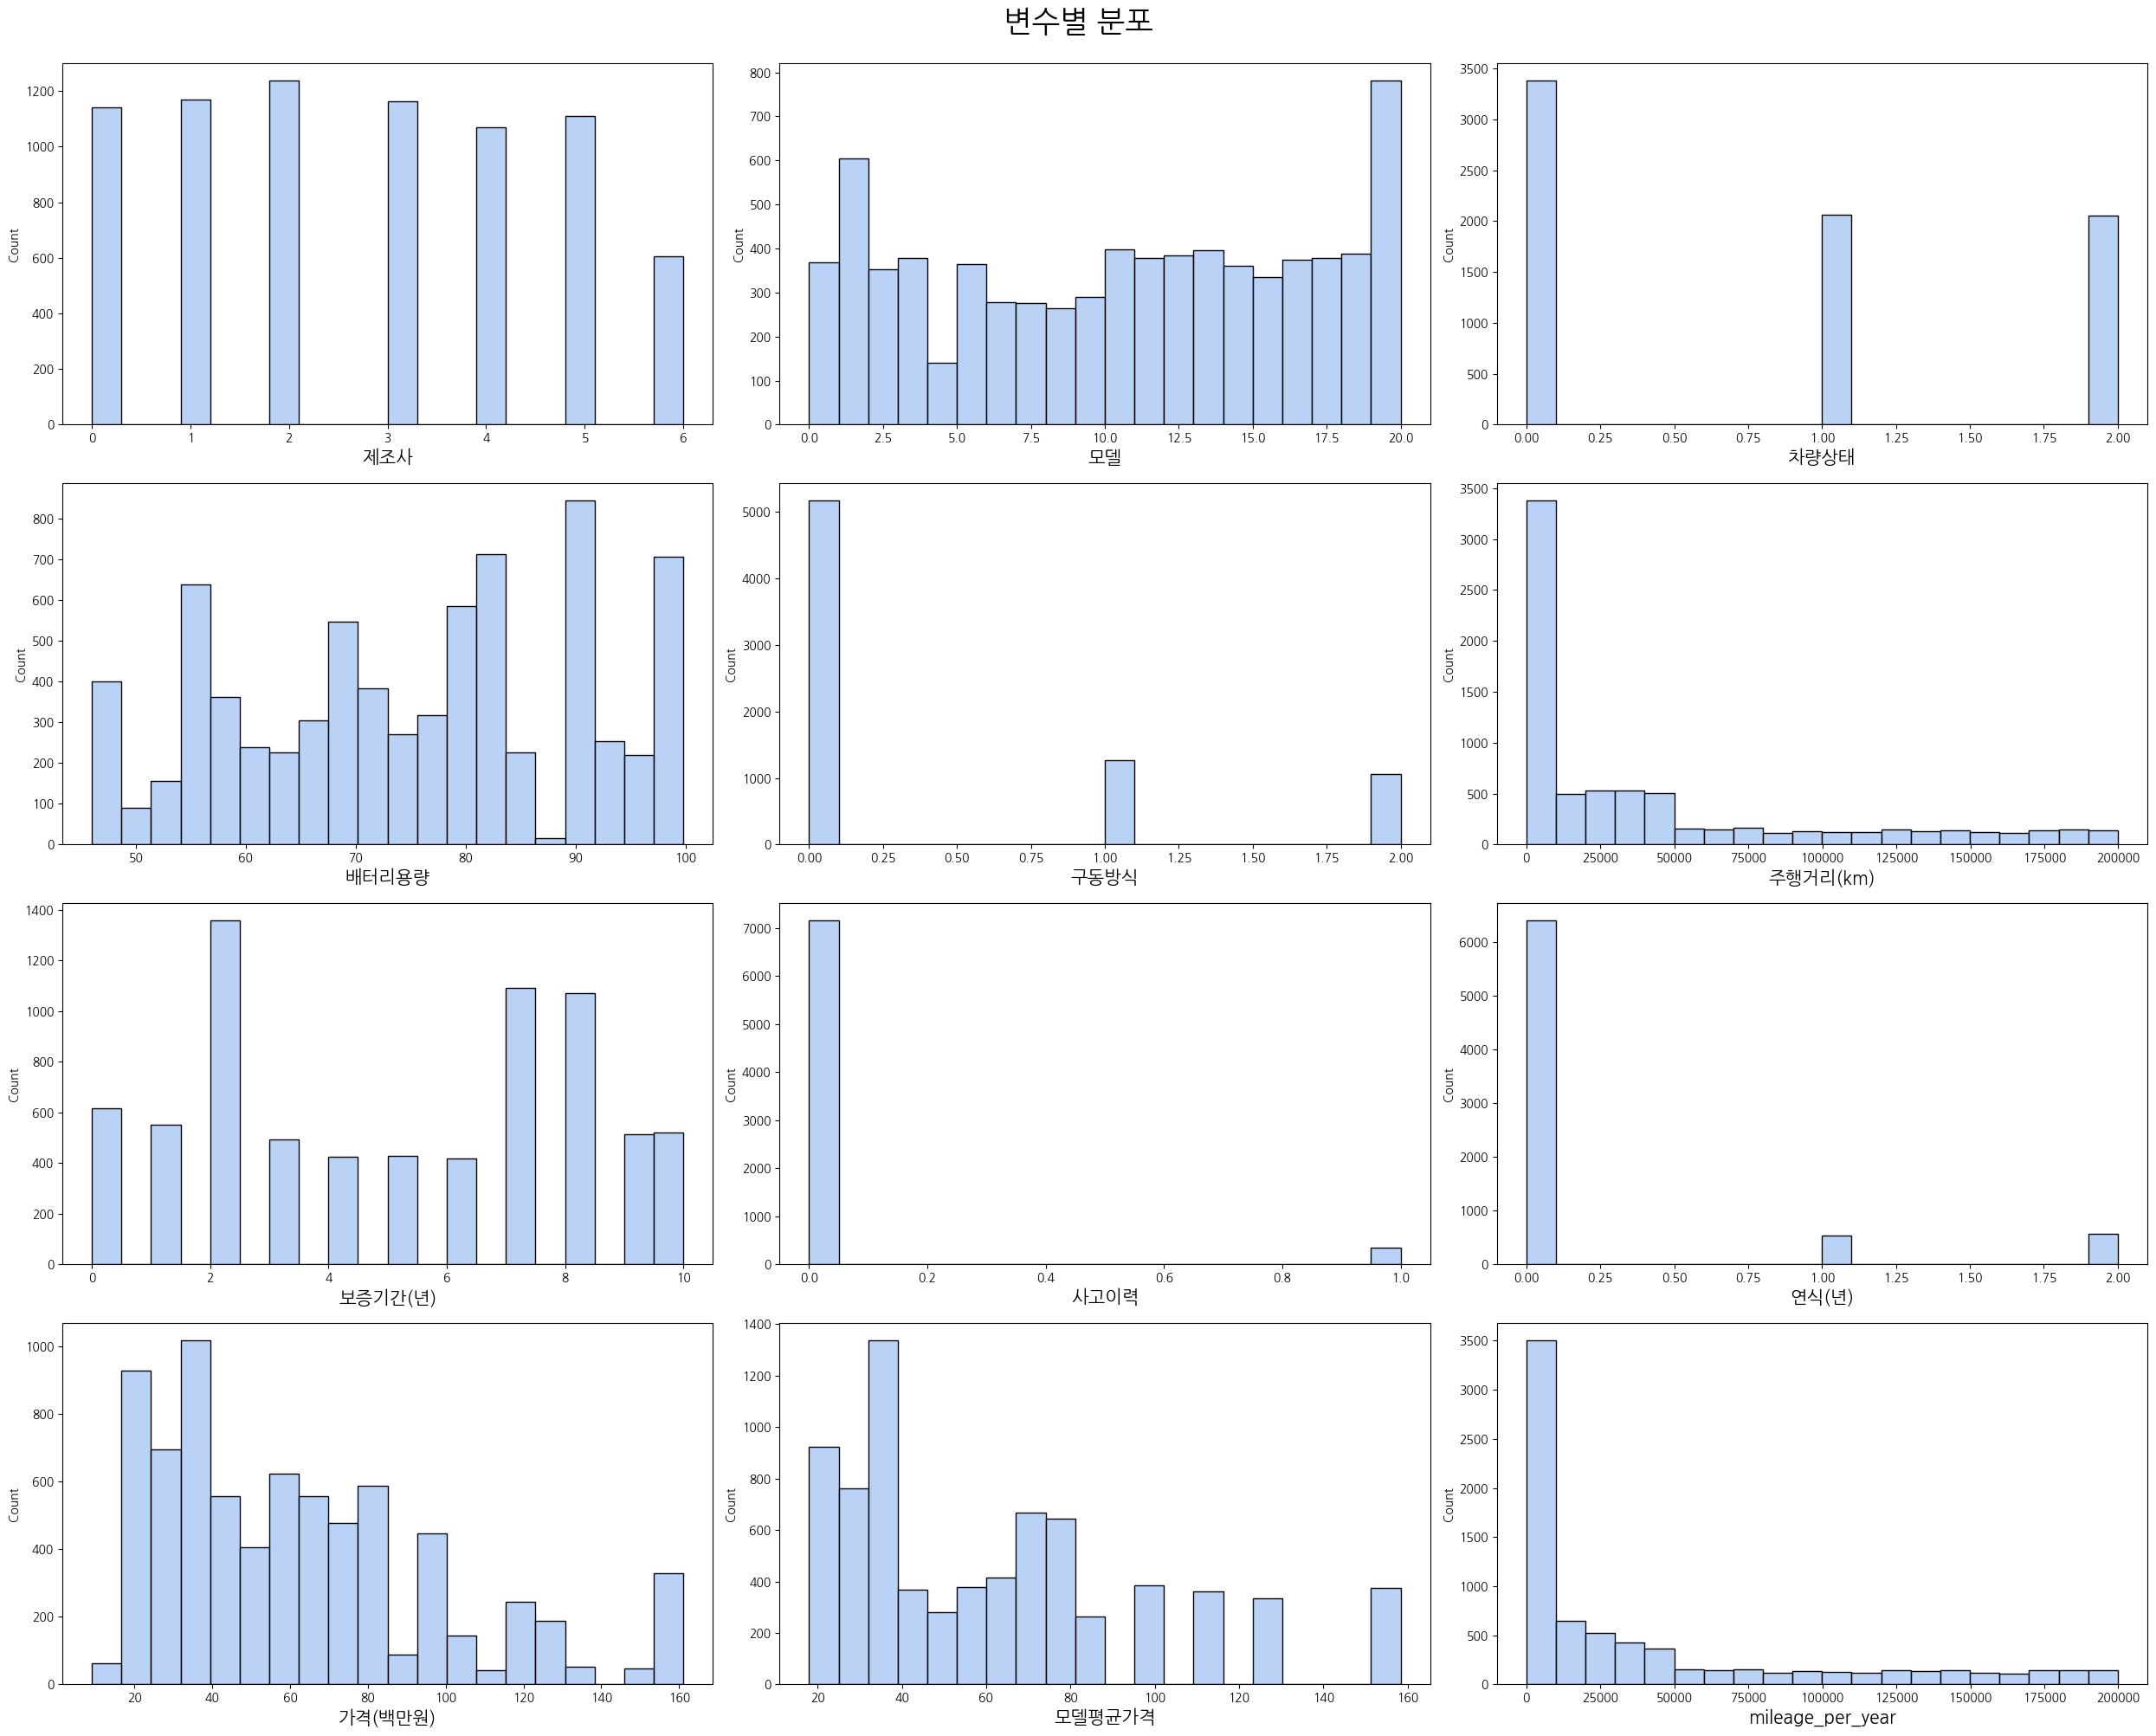

In [ ]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in train:
  if col != 'ID':
    if plotnumber <= 12:
      ax = plt.subplot(4, 3, plotnumber)
      sns.histplot(train[col], bins = 20, color = '#a3c4f3')
      plt.xlabel(col, fontsize = 15)
    plotnumber += 1

plt.suptitle("변수별 분포", y = 1, size = 25, fontweight = 'bold')
plt.tight_layout()
plt.show()

#### Scatterplot Matrix

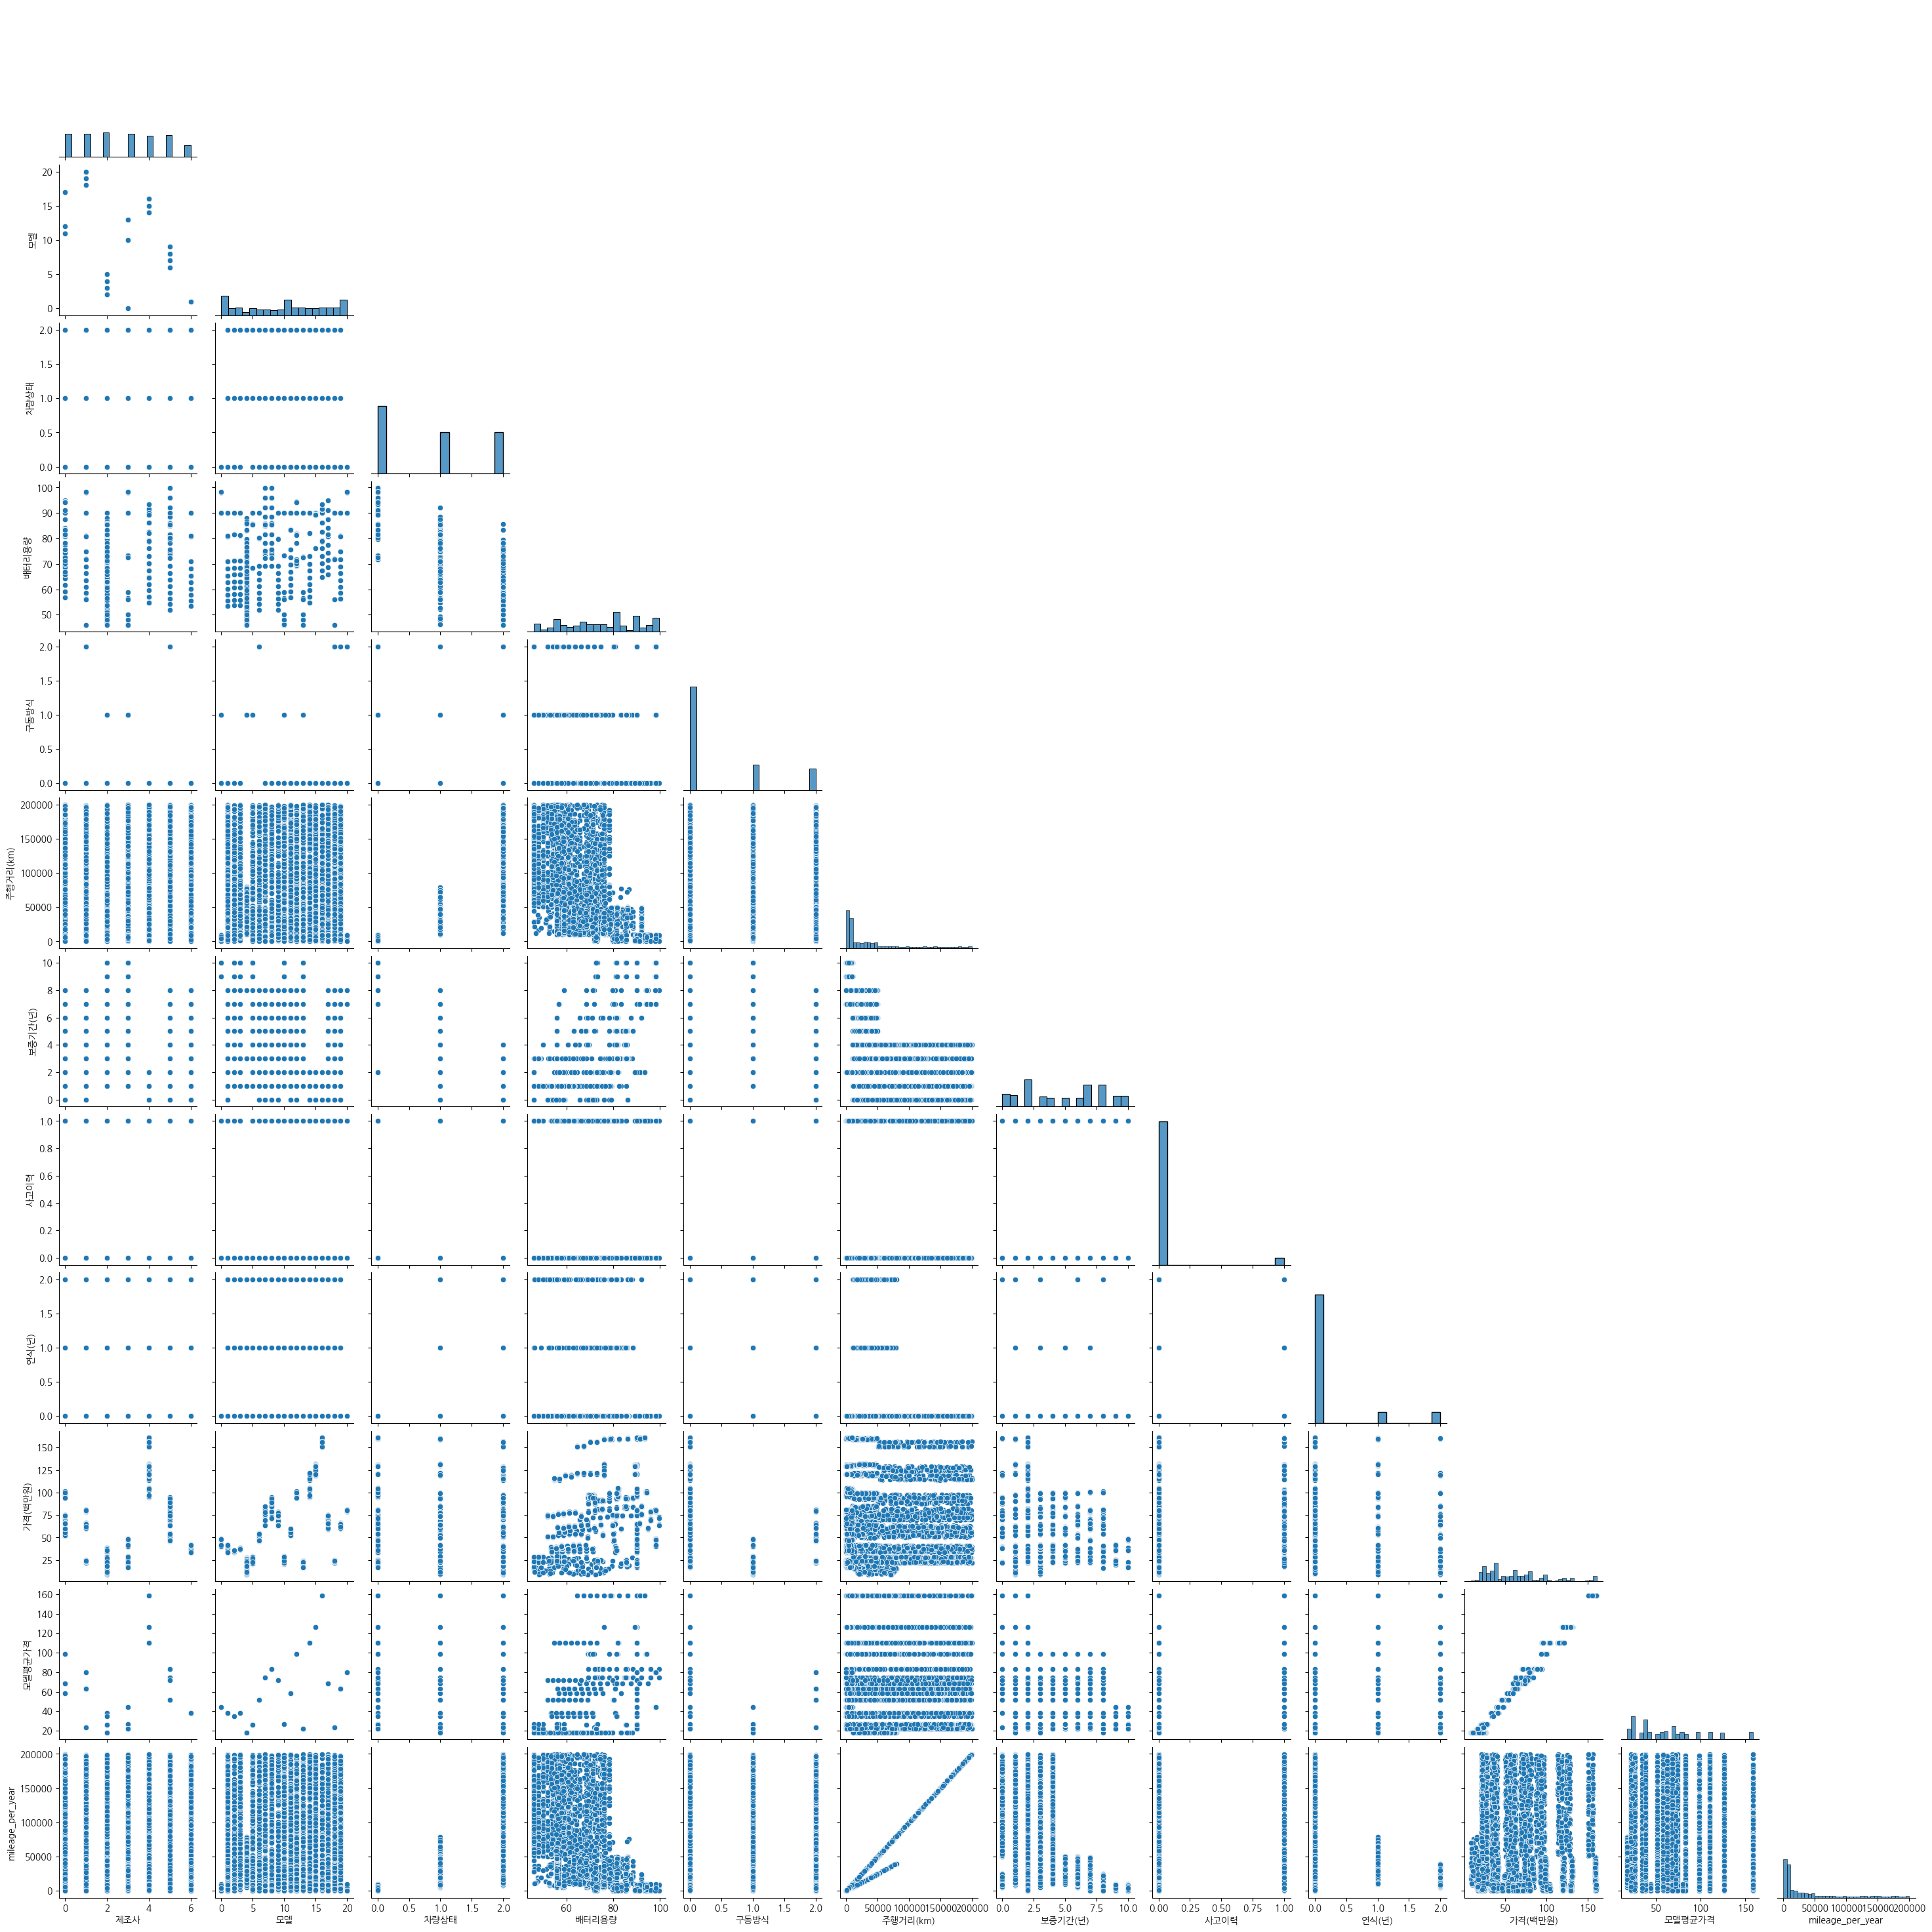

In [ ]:
sns.pairplot(train, palette='viridis', corner=True)
plt.show()

#### 히트맵

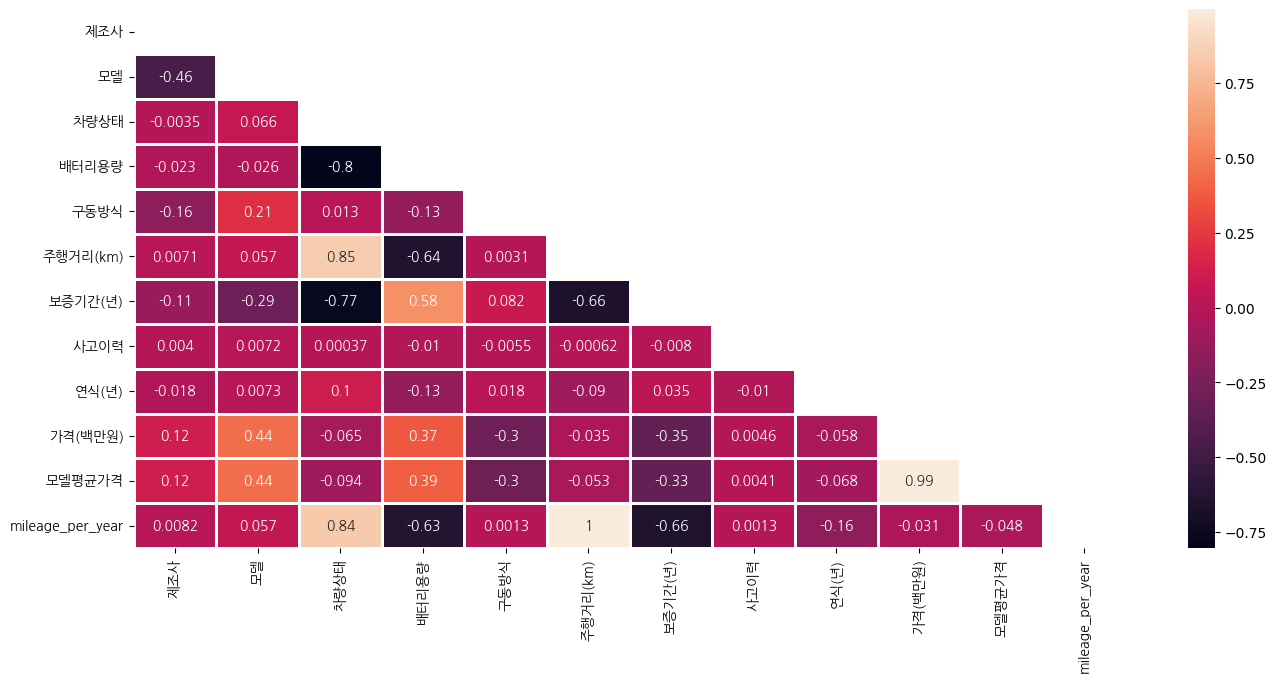

In [ ]:
plt.figure(figsize = (16, 7))

corr = train.corr(numeric_only = True)
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(corr, mask = mask, annot = True, fmt = '0.2g', linewidths = 1)

cbar = plt.gca().collections[0].colorbar
for label in cbar.ax.get_yticklabels():
    label.set_fontname('DejaVu Sans')

plt.show()

가격(백만원)과 다른 변수들 간에 상관계수가 크지 않음을 알 수 있음. 따라서 선형성을 가정하는 일반 선형회귀, Ridge 회귀, Lasso 회귀보다는 트리모델을 사용하는 것이 낫겠다는 인사이트를 얻음.

#### 모델평균가격 막대그래프

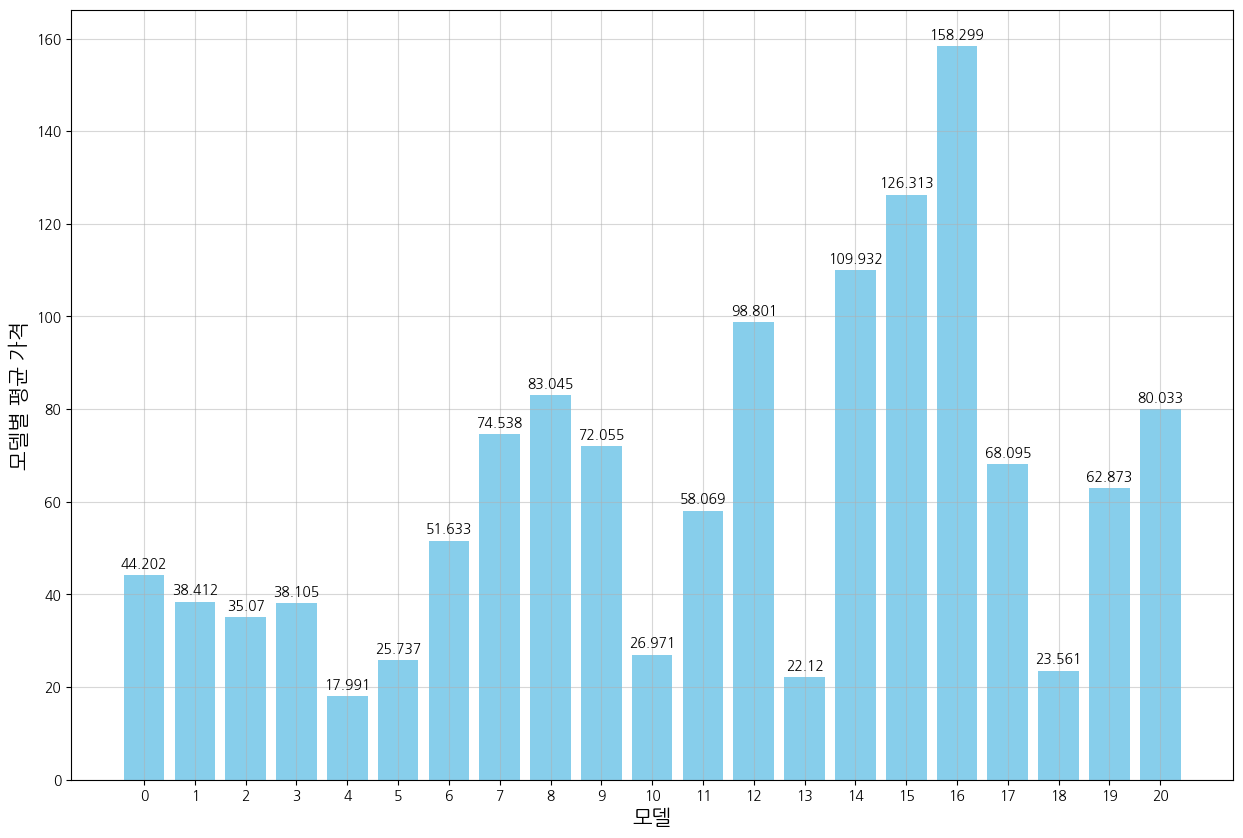

In [ ]:
plt.figure(figsize = (15, 10))
plt.bar(mean_price.index, mean_price, color = 'skyblue')
for i, value in enumerate(mean_price):
	plt.text(i, value + 1, str(round(value, 3)), ha = 'center', va = 'bottom')
plt.xticks(mean_price.index, mean_price.index)
plt.xlabel('모델', fontsize = 15)
plt.ylabel('모델별 평균 가격', fontsize = 15)
plt.grid(True, alpha = 0.5)
plt.show()

모델별로 모델평균가격의 편차가 큼을 확인할 수 있음 -> '모델평균가격'을 하나의 열로 넣는 것이 타당함




## 모델 적합

#### 데이터프레임 정리

In [ ]:
# 'ID'는 고유 번호일뿐이며, '제조사'의 정보는 '모델'의 정보로 대체 가능하므로 drop
train = train.drop(['제조사', 'ID'], axis = 1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 가격(백만원) 열을 제외한 df 데이터프레임 생성
df = train.drop(['가격(백만원)'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif['features'] = df.columns
vif

# 앞서 피처들을 활용해 배터리용량의 예측값을 생성했으므로, 배터리용량의 vif가 높은 것은 자연스러움. 나머지 변수들 간에는 다중공선성 없어보임.

,VIF Factor,features
0,5.359951,모델
1,9.546397,차량상태
2,47.123782,배터리용량
3,1.822128,구동방식
4,713.514098,주행거리(km)
5,16.857753,보증기간(년)
6,1.047678,사고이력
7,4.017988,연식(년)
8,13.995873,모델평균가격
9,720.042623,mileage_per_year


In [ ]:
# 다음으로 VIF 값이 큰 보증기간(년) 변수 제거
df = train.drop(['가격(백만원)', '주행거리(km)'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif['features'] = df.columns
vif
# 다중공선성 완화됨 -> 최종적으로 보증기간(년) 변수 제거 결정

,VIF Factor,features
0,5.352891,모델
1,9.464784,차량상태
2,46.855572,배터리용량
3,1.821481,구동방식
4,16.731169,보증기간(년)
5,1.047032,사고이력
6,1.542631,연식(년)
7,13.958458,모델평균가격
8,6.918719,mileage_per_year


In [ ]:
train = train.drop('주행거리(km)', axis = 1)
train

,모델,차량상태,배터리용량,구동방식,보증기간(년),사고이력,연식(년),가격(백만원),모델평균가격,mileage_per_year
0,16,1,86.077000,0,0,0,2,159.66,158.298747,6821.0
1,10,1,56.000000,1,6,0,0,28.01,26.970779,10199.0
2,17,0,91.200000,0,7,0,0,66.27,68.095251,2361.0
3,12,1,81.584705,0,3,0,0,99.16,98.801195,21683.0
4,19,2,61.018000,0,1,0,0,62.02,62.873382,178205.0
...,...,...,...,...,...,...,...,...,...,...
7492,2,0,81.553992,0,10,0,0,35.95,35.070142,3773.0
7493,18,2,46.000000,2,2,0,0,23.40,23.561108,135411.0
7494,15,0,89.369808,0,2,0,0,120.00,126.312657,1363.0
7495,18,1,56.000000,2,6,0,2,24.00,23.561108,19722.5


### 데이터 분할, 표준화, RF 적합

In [ ]:
from sklearn.model_selection import GridSearchCV
# (1) 독립변수(x)와 종속변수(y) 설정
X = train.drop("가격(백만원)", axis = 1)
y = train["가격(백만원)"]

# (2) 데이터 split - 80:20으로 분할(validation set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# (3) 표준화
scaler2 = StandardScaler()
X_train = scaler2.fit_transform(X_train)
X_test = scaler2.transform(X_test)

# (4) RandomForestRegressor
rf = RandomForestRegressor()
rf_params = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}
rf_cv_model = RandomizedSearchCV(rf, rf_params, cv = 5,
                                 scoring = 'neg_root_mean_squared_error')
rf_cv_model.fit(X_train, y_train)
rf_model = RandomForestRegressor(n_estimators = rf_cv_model.best_params_["n_estimators"],
                                max_depth = rf_cv_model.best_params_["max_depth"],
                                min_samples_split = rf_cv_model.best_params_["min_samples_split"],
                                min_samples_leaf = rf_cv_model.best_params_['min_samples_leaf'])


rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
print("best n_estimators: " + str(rf_cv_model.best_params_["n_estimators"]),
     "\nbest max_depth: " + str(rf_cv_model.best_params_["max_depth"]),
     "\nbest min_samples_split: " + str(rf_cv_model.best_params_["min_samples_split"]),
     "\nbest min_samples_leaf: " + str(rf_cv_model.best_params_["min_samples_leaf"]))

from sklearn import metrics
print("----------------------")
print(f"Model Performance:")
print(f"  MSE: {metrics.mean_squared_error(y_test, y_pred_rf)}")
print(f"  MAE: {metrics.mean_absolute_error(y_test, y_pred_rf)}")
print(f"  RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))}")
print(f"  R2 Score: {metrics.r2_score(y_test, y_pred_rf)}")

best n_estimators: 200 
best max_depth: 30 
best min_samples_split: 2 
best min_samples_leaf: 5
----------------------
Model Performance:
  MSE: 1.7368728246263248
  MAE: 0.6825887334106082
  RMSE: 1.3179047099947419
  R2 Score: 0.9988032657885753


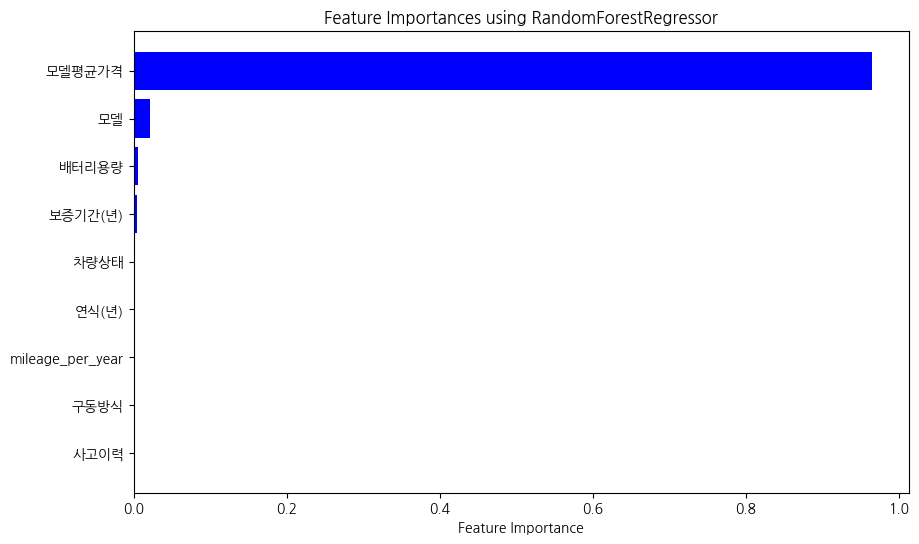

In [ ]:
# RandomForestRegressor 모델의 Feature Importance

feature_names = X.columns # feature names 가져오기
importances = rf_model.feature_importances_ # feature importance 가져오기
sorted_importances = np.argsort(importances)[::-1] # feature importance를 내림차순으로 정렬한 인덱스



plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_importances], importances[sorted_importances], color = 'blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances using RandomForestRegressor')
plt.gca().invert_yaxis()  # 중요한 feature부터 위에 표시
plt.show()

### test셋 적합

In [ ]:
# test set 전처리
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/KUBIG/25-1/Basic Study_ML/test.csv')

# 범주형 변수 레이블 인코딩
for col in test:
    if (test[col].dtype == 'object') & (col != 'ID'):
        le = LabelEncoder()
        test[col] = le.fit_transform(test[col])

# 배터리용량 결측치 대체값 생성
# (1) 모델별 배터리용량의 평균 구하기(mean_battery_per_model) - 각 행에 각 모델에 해당하는 평균 배터리용량 열(mean_battery) 추가
mean_battery_per_model = test.groupby('모델')['배터리용량'].mean()
test['mean_battery'] = test['모델'].map(mean_battery_per_model)
# (2) '배터리용량'이 결측값인 행은 제거하여 train 데이터셋 생성 - 독립변수(X)는 '차량상태', '주행거리', 'mean_battery', 타겟(y)는 '배터리용량'으로 설정
test_no_na = test.dropna(subset = ['배터리용량'])
X = test_no_na[['차량상태', '주행거리(km)', 'mean_battery']]
y = test_no_na['배터리용량']
# (3) Ridge 모델 학습 - 훈련 데이터에 이용한 모델 그대로 이용
X = scaler1.transform(X)
ridge_model.fit(X, y)

# (4) '배터리용량'이 결측값인 행을 찾아서 예측값 생성 후 결측값 채우기
test_na = test[test['배터리용량'].isna()]
X_na = test_na[['차량상태', '주행거리(km)', 'mean_battery']]

X_na = scaler1.transform(X_na)
y_na_pred = ridge_model.predict(X_na)
test.loc[test['배터리용량'].isna(), '배터리용량'] = y_na_pred

# 파생변수 생성
# (1) 모델평균가격
mean_price = train.groupby(['모델'])['가격(백만원)'].mean() # test set에는 가격이 안 나와있으므로 train set에서 구한 평균 가격 이용
test['모델평균가격'] = test['모델'].map(mean_price)
# (2) mileage_per_year
test['mileage_per_year'] = test.apply(
    lambda row: row['주행거리(km)'] / row['연식(년)'] if row['연식(년)'] != 0 else row['주행거리(km)'],
    axis=1)

# 불필요한 열 & 다중공선성 유발하는 열(주행거리) drop
test = test.drop(['제조사', 'ID', 'mean_battery', '주행거리(km)'], axis = 1)

test

,모델,차량상태,배터리용량,구동방식,보증기간(년),사고이력,연식(년),모델평균가격,mileage_per_year
0,15,1,76.093000,0,2,0,0,126.312657,14057.0
1,20,0,90.000000,0,8,0,0,80.032534,7547.0
2,19,0,82.385928,2,7,1,0,62.873382,7197.0
3,2,1,68.479000,0,7,0,1,35.070142,10357.0
4,0,0,98.103032,1,10,0,0,44.202493,7597.0
...,...,...,...,...,...,...,...,...,...
841,16,2,64.683000,0,2,0,0,158.298747,117298.0
842,1,2,55.547000,0,0,0,0,38.411702,72308.0
843,1,2,55.547000,0,0,0,0,38.411702,124537.0
844,11,1,69.646000,0,4,0,0,58.068836,15629.0


In [ ]:
test = scaler2.transform(test)
y_test_pred = rf_model.predict(test)

In [ ]:
submit = pd.read_csv('/content/drive/My Drive/Colab Notebooks/KUBIG/25-1/Basic Study_ML/sample_submission.csv')
submit['가격(백만원)'] = y_test_pred
submit.head()
submit.to_csv("/content/drive/My Drive/Colab Notebooks/KUBIG/25-1/Basic Study_ML/submission_0222_5.csv", index=False)